In [2]:
# Import Libraries

import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import pyreadr
import seaborn as sns
import session_info
import upsetplot

## Pandas Missing Extension

In [3]:
%run pandas-missing-extension.ipynb

In [4]:
# Settings
%matplotlib inline

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',200)
pd.options.display.float_format= '{:.2f}'.format

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

sns.set(
    rc={
        "figure.figsize": (10, 10)
    }
)

sns.set_style("whitegrid")

### Extract Data

In [5]:
base_url = "https://github.com/njtierney/naniar/raw/master/data/"
datasets_names = ("oceanbuoys", "pedestrian")
extension = ".rda"

In [6]:
datasets_dfs = {}

for dataset_name in datasets_names:

    dataset_file = f"{ dataset_name }{ extension }"
    dataset_output_file = f"./data/{ dataset_file }"
    dataset_url = f"{ base_url }{ dataset_file }"
    
    !wget -q -O { dataset_output_file } { dataset_url }

    datasets_dfs[f"df_{ dataset_name }"] = pyreadr.read_r(dataset_output_file).get(dataset_name)

datasets_dfs.keys()

dict_keys(['df_oceanbuoys', 'df_pedestrian'])

In [7]:
locals().update(**datasets_dfs)
del datasets_dfs

In [8]:
df_oceanbuoys.shape

(736, 8)

In [9]:
df_oceanbuoys.isnull().sum()

year           0
latitude       0
longitude      0
sea_temp_c     3
air_temp_c    81
humidity      93
wind_ew        0
wind_ns        0
dtype: int64

En este análisis preliminar, notamos que existen 3 variables con valores nulos:  sea_temp_c, sea_temp_c y humidity

The one how has more quantity of null values is Humidity (93 values).

In [10]:
df_oceanbuoys.head()

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns
0,1997.00,0.00,-110.00,27.59,27.15,79.60,-6.40,5.40
1,1997.00,0.00,-110.00,27.55,27.02,75.80,-5.30,5.30
2,1997.00,0.00,-110.00,27.57,27.00,76.50,-5.10,4.50
3,1997.00,0.00,-110.00,27.62,26.93,76.20,-4.90,2.50
4,1997.00,0.00,-110.00,27.65,26.84,76.40,-3.50,4.10


In [11]:
df_oceanbuoys.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,year,0,736,0.00
1,latitude,0,736,0.00
2,longitude,0,736,0.00
3,sea_temp_c,3,736,0.41
4,air_temp_c,81,736,11.01
5,humidity,93,736,12.64
6,wind_ew,0,736,0.00
7,wind_ns,0,736,0.00


Humidity's null values represent almost 13% of the cases for this variable

In [14]:
df_oceanbuoys.missing.missing_variable_table()

,n_missing_in_variable,n_variables,pct_variables
0,0,5,62.50
1,3,1,12.50
2,81,1,12.50
3,93,1,12.50


In [16]:
df_oceanbuoys.missing.missing_case_summary().sort_values(by='n_missing', ascending=False)

,case,n_missing,pct_missing
480,480,3,30.00
462,462,3,30.00
636,636,2,20.00
459,459,2,20.00
121,121,1,10.00
...,...,...,...
297,297,0,0.00
298,298,0,0.00
299,299,0,0.00
300,300,0,0.00


In [33]:
df_oceanbuoys.iloc[636]

year         1993.00
latitude       -2.00
longitude     -95.00
sea_temp_c       NaN
air_temp_c       NaN
humidity       89.90
wind_ew        -3.40
wind_ns         2.40
Name: 636, dtype: float64

In [22]:
df_oceanbuoys.iloc[480]

year         1993.00
latitude        0.00
longitude     -95.00
sea_temp_c       NaN
air_temp_c       NaN
humidity         NaN
wind_ew        -6.30
wind_ns         0.50
Name: 480, dtype: float64

In [23]:
df_oceanbuoys.iloc[462]

year         1993.00
latitude        0.00
longitude     -95.00
sea_temp_c       NaN
air_temp_c       NaN
humidity         NaN
wind_ew        -5.60
wind_ns         3.10
Name: 462, dtype: float64

In all the cases that the varioable "sea_temp_c" is null, "air_temp_c" is also null.

That could be an important finding because it could be a Missing Not at Random (MNAR) behabior. 

In [31]:
(
    df_oceanbuoys.missing.missing_variable_span(
        variable='humidity',
        span_every=60
    )
)

,span_counter,n_missing,n_complete,pct_missing,pct_complete
0,0,0,60,0.00,100.00
1,1,0,60,0.00,100.00
2,2,0,60,0.00,100.00
3,3,0,60,0.00,100.00
4,4,0,60,0.00,100.00
5,5,0,60,0.00,100.00
6,6,0,60,0.00,100.00
7,7,21,39,35.00,65.00
8,8,60,0,100.00,0.00
9,9,12,48,20.00,80.00


Here we can see that the null values are grouping at bins 7,8,9 (groupping by 60)

In [34]:
(
    df_oceanbuoys.missing.missing_variable_run(
        variable='humidity',
        
    )
)

,run_length,is_na
0,459,complete
1,93,missing
2,184,complete


In [35]:
(
    df_oceanbuoys.missing.missing_variable_run(
        variable='air_temp_c',
        
    )
)

,run_length,is_na
0,107,complete
1,77,missing
2,275,complete
3,1,missing
4,2,complete
5,1,missing
6,17,complete
7,1,missing
8,155,complete
9,1,missing


For the Humidity variable, we have 459 records complete follow by 93 missing values.

For the air_temp variable, the missing records are a bit more scatted. But after 107 complete records, we have 77 missing values. That reperent the 95% of the total missing values.

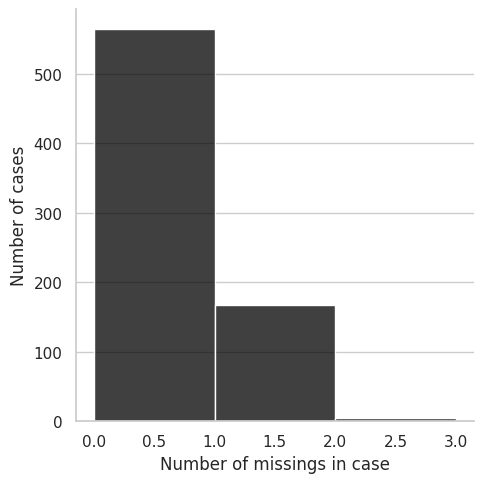

In [37]:
df_oceanbuoys.missing.missing_case_plot()

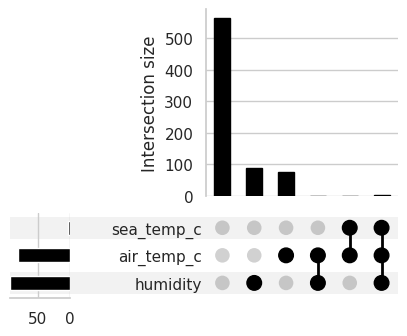

In [40]:
(
    df_oceanbuoys
    .missing
    .missing_upsetplot(
        variables=['sea_temp_c', 'air_temp_c', 'humidity'], # None para mostrar la relacion de todas las variables
        element_size = 30  # tamaño de la visualizacion
    )
)
plt.show()

<AxesSubplot:>

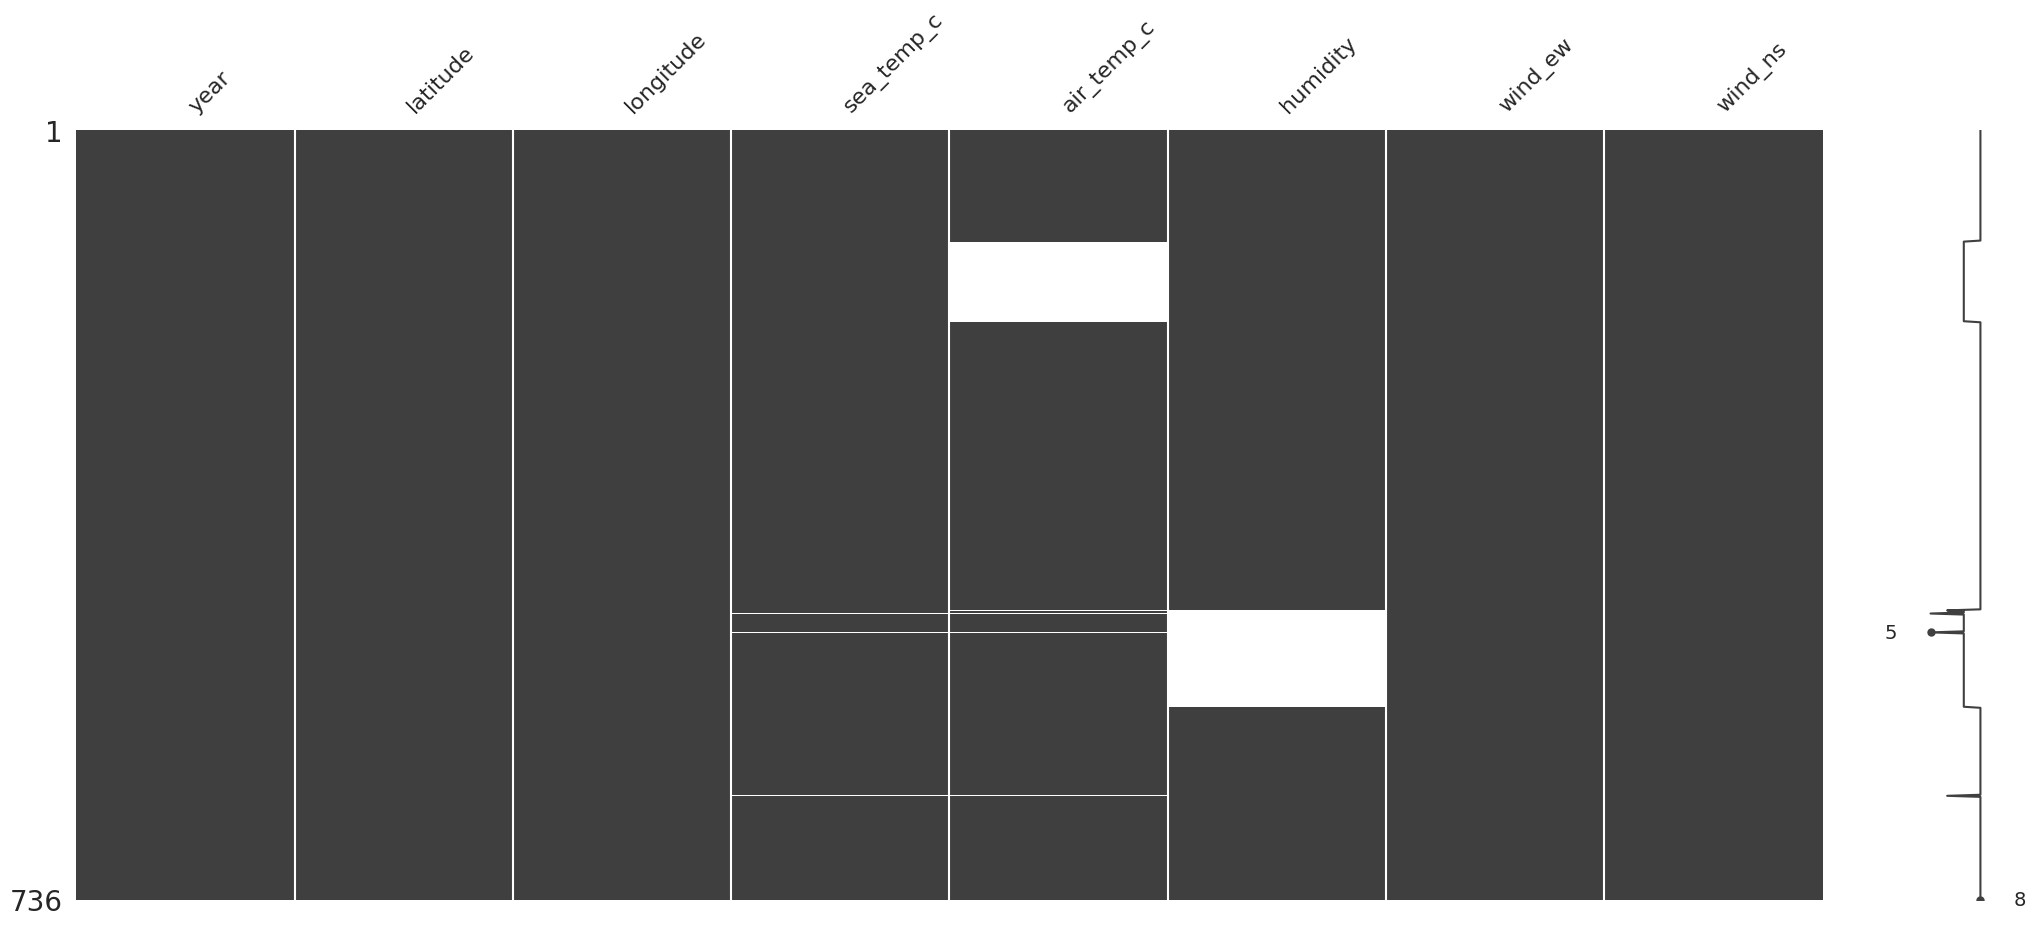

In [41]:
missingno.matrix(df = df_oceanbuoys)

## Shadow Matrix

In [43]:
(
    df_oceanbuoys
    .missing
    .bind_shadow_matrix(only_missing=True) # con este parámetro = True solo se pasaran las variables que tienen valores faltantes
)

,year,latitude,longitude,sea_temp_c,air_temp_c,humidity,wind_ew,wind_ns,sea_temp_c_NA,air_temp_c_NA,humidity_NA
0,1997.00,0.00,-110.00,27.59,27.15,79.60,-6.40,5.40,Not Missing,Not Missing,Not Missing
1,1997.00,0.00,-110.00,27.55,27.02,75.80,-5.30,5.30,Not Missing,Not Missing,Not Missing
2,1997.00,0.00,-110.00,27.57,27.00,76.50,-5.10,4.50,Not Missing,Not Missing,Not Missing
3,1997.00,0.00,-110.00,27.62,26.93,76.20,-4.90,2.50,Not Missing,Not Missing,Not Missing
4,1997.00,0.00,-110.00,27.65,26.84,76.40,-3.50,4.10,Not Missing,Not Missing,Not Missing
...,...,...,...,...,...,...,...,...,...,...,...
731,1993.00,-2.00,-110.00,24.78,24.62,90.80,-4.40,1.70,Not Missing,Not Missing,Not Missing
732,1993.00,-2.00,-110.00,24.88,24.50,91.10,-3.00,0.20,Not Missing,Not Missing,Not Missing
733,1993.00,-2.00,-110.00,25.12,24.89,89.70,-4.00,1.10,Not Missing,Not Missing,Not Missing
734,1993.00,-2.00,-110.00,25.16,24.93,89.50,-4.30,2.50,Not Missing,Not Missing,Not Missing


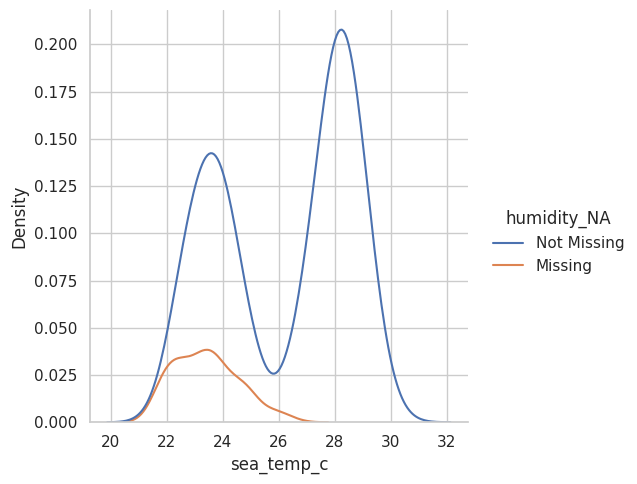

In [46]:
(
    df_oceanbuoys
    .missing.bind_shadow_matrix(only_missing=True)
    .pipe(
lambda df: (
            sns.displot(
                data=df,
                x = 'sea_temp_c', #variable de distribucion
                hue = 'humidity_NA',  #variable de comparacion
                kind= 'kde' #distribucion de densidad
            )
        )
    )
)